In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

from IPython.display import display, clear_output
from PIL import Image

from stable_fluid.fluid import Fluid

#z, y, x순서임.
#근데 speed[0]은 x벡터의 크기, speed[1]은 y벡터의 크, speed[2]는 z벡터의 크기 됨 주의.
RESOLUTION = 500, 500
DURATION = 80000

INFLOW_DURATION = 8000
INFLOW_VELOCITY = 0.1
INFLOW_COUNT = 1


In [2]:

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device: ", device)
fluid = Fluid(RESOLUTION, 'dye', device = device)

inflow_velocity = torch.zeros_like(fluid.velocity, device=device)
inflow_velocity[1, 23:25, 246:254] += INFLOW_VELOCITY
inflow_dye = torch.zeros(fluid.shape, device=device)
inflow_dye[23:25, 246:254] = 0.5
#inflow_dye[470:480, 245:255] = 1.0

device:  cuda


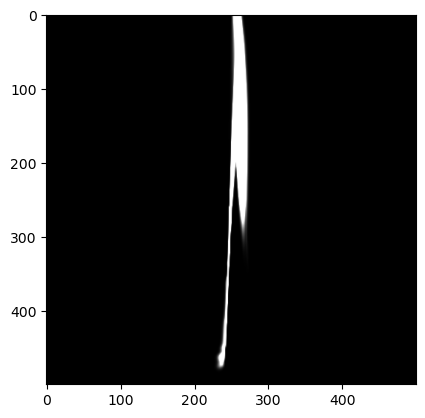

In [ ]:

plt.ioff()  # interactive mode 끄기
fig, ax = plt.subplots()
im = ax.imshow(np.zeros(RESOLUTION), cmap='gray', vmin=0, vmax=1)

for f in range(DURATION):
    
    if f <= INFLOW_DURATION:
        fluid.velocity += inflow_velocity
        fluid.dye += inflow_dye
    fluid.step(dt = 0.03)
    '''
    velocity = fluid.velocity.cpu().numpy()
    
    speed = np.linalg.norm(velocity, axis=0)
    max_val = np.max(speed)
    if max_val > 0:
        speed_norm = speed / max_val
    else:
        speed_norm = speed
    '''
    if(f % 100 == 0):
        print(f'Computing frame {f + 1} of {DURATION}.')
        dye_cpu = fluid.dye.cpu().numpy()[::-1, :]
        dye_cpu[dye_cpu >= 1] = 1
        frame = dye_cpu
        
        im.set_data(frame)
        clear_output(wait=True)
        display(fig)
    